# Model NEATM 余亮亮 修改 $\alpha, \phi$
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


### test Fortran

In [2]:
import os
d = 1.12554
delta = 1.14078
alpha = 0
D = 40.0
lamda = 12.0
eta = 1.23
A = 0.0505
para = str(d)+' '+str(delta)+' '+str(alpha)+' '+str(D)+' '+str(lamda)+' '+str(eta)+' '+str(A)
exe ='./a.out '+' '+para 
ret = os.system(exe)
f = os.popen(exe)
print("hello=",f.readline())
f.close()
#print('./a.out '+' '+para)


   8.8757144855184248E-005
hello=    8.8757144855184248E-005



# MCMC_NEATM

## define const & import

In [3]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 20
G = 0.15
Ndd = 15
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

In [4]:
#ret = os.popen('./a.out 2 6')
#a1 = ret.readlines()
def Model_neatm_hhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        ret = os.system('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda1)+' '+str(A)+' '+str(Ndd))
        #print('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda1)+' '+str(A))
        flux[i] = ret
    for i in range(int(nn/2),nn):
        ret = os.system('./neatm '+str(eta)+' '+str(D)+' '+str(delta[i])+' '+str(d[i])+' '+str(alpha[i])+' '+str(lamda2)+' '+str(A)+' '+str(Ndd))
        flux[i] = ret
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

In [5]:
#ret = os.popen('./a.out 2 6')
def Model_neatm_fort(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        para = str(d[i])+' '+str(delta[i])+' '+str(alpha[i])+' '+str(D)+' '+str(lamda1)+' '+str(eta)+' '+str(A)
        exe ='./a.out '+' '+para 
        f = os.popen(exe)
        flux[i] = f.readline()
        f.close()
    for i in range(int(nn/2),nn):
        para = str(d[i])+' '+str(delta[i])+' '+str(alpha[i])+' '+str(D)+' '+str(lamda2)+' '+str(eta)+' '+str(A)
        exe ='./a.out '+' '+para 
        f = os.popen(exe)
        flux[i] = f.readline()
        f.close()
    return flux

In [6]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd)
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = -pi/2.0 + i * pi / Nd
	nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = pi/Nd,pi/Nd
	ss = dphi*dtheta#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(int(nj),len(theta)):
			temp[j,k] = T_ss * np.cos(theta[k]) ** 0.25 * np.cos(phi[j]) ** 0.25
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## read data file

处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [7]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = namelist[0].lower()

计算delta d 看看对不对

In [8]:
obsec = np.loadtxt(f'epoch_{name}.txt')
#print(obsec)
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)

[1.18545275 1.18241596 1.16796783 1.16492285 1.13057508 1.11603063
 0.07475346 0.07467717 1.18545275 1.18241596 1.16796783 1.16492285
 1.13057508 1.11603063 0.07475346 0.07467717]


ast-sun [1.52721913 1.52679108 1.52470944 1.52426124 1.51897647 1.51661172
 1.01612708 1.01566025 1.52721913 1.52679108 1.52470944 1.52426124
 1.51897647 1.51661172 1.01612708 1.01566025]
ast-earth [1.18545275 1.18241596 1.16796783 1.16492285 1.13057508 1.11603063
 0.07475346 0.07467717 1.18545275 1.18241596 1.16796783 1.16492285
 1.13057508 1.11603063 0.07475346 0.07467717]
earth-sun [0.99597815 0.99603944 0.99633264 0.99639474 0.99710007 0.99740022
 1.01426875 1.01426754 0.99597815 0.99603944 0.99633264 0.99639474
 0.99710007 0.99740022 1.01426875 1.01426754]
alpha [40.68540727 40.70533249 40.79808254 40.81719502 41.02211982 41.10288654
 86.46718739 86.82420176 40.68540727 40.70533249 40.79808254 40.81719502
 41.02211982 41.10288654 86.46718739 86.82420176] 



/tmp/ipykernel_178975/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_178975/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


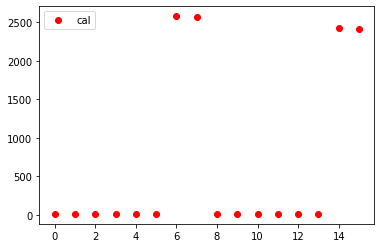

In [101]:
obsec = np.loadtxt(f'epoch_{name}.txt')
obsdat = np.loadtxt(f'obs_w3_{name}.txt')

#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
print('ast-sun',d_N)

#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
print('ast-earth',delta_N)

#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
print('earth-sun',dd_N)

#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
print("alpha",alpha_N/pi*180,'\n')
y = obsdat
nt = np.arange(len(d_N))
theta = [1.2,780]
flux = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
#plt.plot(nt,flux,label = 'hhq')
#print(flux)
#plt.plot(nt[0:len(d_N)],obsdat[0:len(d_N)],'bo',label = 'obs')
plt.plot(nt[0:len(d_N)],flux[0:len(d_N)],'ro',label = 'cal')
#plt.plot(nt[0:len(d_N)],alpha_N[0:len(d_N)],'go',label = 'alpha')
#print(flux[0:len(d_N)])
plt.legend()
lenthi = [8,30,100]
dddd = (lenthi[1]-lenthi[0])/lenthi[2]
lenth = lenthi[0]
D = 136
pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
q = 0.29+0.684*G
A = q*pv
flamda = []
nlenth  = []
for i in range(lenthi[2]):
    lenth = lenth+dddd
    nlenth.append(lenth)
    flamda.append((neatm_jhx(Ndd,d_N[1],delta_N[1],alpha_N[1],D,lenth,1.2,A)))
#plt.plot(nlenth,flamda,label = 'cal')  


## define MCMC_function

In [7]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.01,5]
D_gss = [1,500]

In [8]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D= theta
    model = Model_neatm_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [9]:
#initial para guesses
eta = eta_gs
D = D_gs
theta = [eta, D]

In [10]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

emcee: Exception while calling your likelihood function:
  params: [  1.19999899 150.00000037]
  args: ((array([1.19319568, 1.19319421, 1.19243686, 1.19167795, 1.19092041,
       1.18940357, 1.18864427, 1.18788488, 0.20100394, 0.1993999 ,
       0.19833393, 0.19833291, 0.19780053, 0.19514276, 0.19091119,
       1.19319568, 1.19319421, 1.19243686, 1.19167795, 1.19092041,
       1.18940357, 1.18864427, 1.18788488, 0.20100394, 0.1993999 ,
       0.19833393, 0.19833291, 0.19780053, 0.19514276, 0.19091119]), array([1.52829565, 1.52829545, 1.5281911 , 1.52808633, 1.52798154,
       1.5277711 , 1.52766545, 1.52755959, 1.15742678, 1.15617849,
       1.1553464 , 1.1553456 , 1.15492926, 1.15284306, 1.14949444,
       1.52829565, 1.52829545, 1.5281911 , 1.52808633, 1.52798154,
       1.5277711 , 1.52766545, 1.52755959, 1.15742678, 1.15617849,
       1.1553464 , 1.1553456 , 1.15492926, 1.15284306, 1.14949444]), array([0.7091959 , 0.70919608, 0.70928469, 0.70937333, 0.70946165,
       0.709638  , 0

Traceback (most recent call last):
  File "/home/astrohhq/.local/lib/python3.8/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_7634/2673846811.py", line 19, in log_probability
    yy=lp + log_likelihood(theta, x, y, yerr)
  File "/tmp/ipykernel_7634/2673846811.py", line 4, in log_likelihood
    model = Model_neatm_jhx(theta,x,lamdai)
NameError: name 'Model_neatm_jhx' is not defined


NameError: name 'Model_neatm_jhx' is not defined

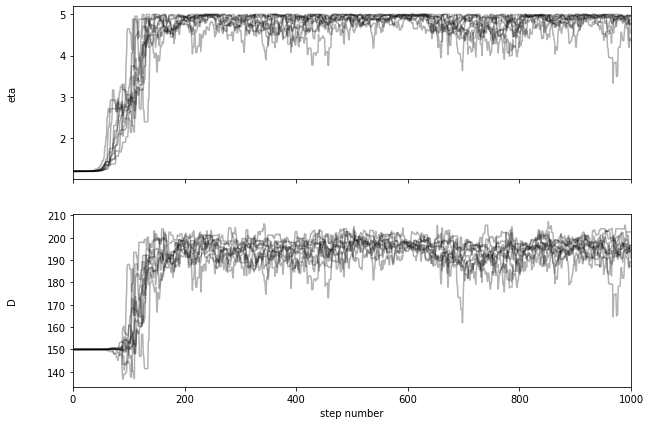

In [ ]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 2)


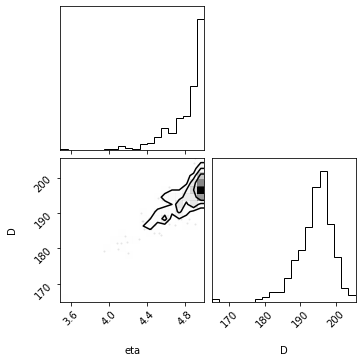

In [ ]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, 103816]
);

In [ ]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.4643749368391371


/tmp/ipykernel_21023/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_21023/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_21023/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_21023/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flu

eta_fit =  4.884274862404494 D_fit=  195.02513846900774


/tmp/ipykernel_21023/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


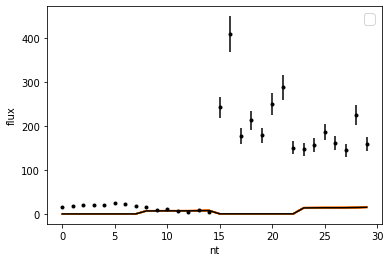

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
#print(nt)
#print(len(flat_samples))
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plt.plot(nt, Model_neatm_jhx(sample,x,lamdai), "C1", alpha=0.1)
plt.errorbar(nt, y, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");

eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit)
theta = eta_fit,D_fit
yt = Model_neatm_jhx(theta,x,lamdai)
plt.plot(nt, yt,"k", label="Most")